# SCOPE
The following notebook is intended to extract insights about item location in the stores and see the corresponding revenue. It is focuse in particular in the items that had just one location (HP) at time 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from google.cloud import bigquery
import pandas as pd

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/salvatore.lovecchio/Library/Python/3.9/lib/python/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
KeyError: '_control_lock'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/salvatore.lovecchio/Library/Python/3.9/lib/python/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/Users/salvatore.lovecchio/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 301, in dispatch_control
    async with self._control_lock:
  File "/Users/salvatore.lovecchio/Library/Python/3.9/lib/python/site-packages/traitlets/traitlets.py", line 687, in __get__
    return t.cast(G, self.get(obj, cls))  # the G should encode the Optional
  File "/Users/salvatore.lovecchio/Library/Python/3.9/lib/python/site-packages/traitlets/t

In [2]:
client = bigquery.Client(project="ingka-sot-cfm-dev")


/Users/salvatore.lovecchio/Library/Python/3.9/lib/python/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:

def get_data_ams(query: bool, saved_path=None):
    """
    Get the questions raw data

    @param query: If True query to get the data, else read from file
    @return: raw data DataFrame
    """
    if query:
        code ="""
    SELECT
      article_id,
      bu_code,
      sales_location_id,
      active,
      PARSE_DATE('%Y%m%d', from_date) AS from_date,
      import_date AS till_date,
      ROW_NUMBER()
        OVER (
          PARTITION BY article_id, bu_code, sales_location_id, from_date
          ORDER BY CAST(import_date AS DATE) DESC
        ) AS row_num
    FROM ingka-cff-slm-prod.slm.article_location_weekly
    WHERE
      1 = 1
      AND import_date >= '2025-09-01'
      AND import_date < '2026-01-20'
      AND bu_code = '274'
      AND active = '1'
    QUALIFY row_num = 1
    
            """
        
        job=client.query(code)
        
        df=job.to_dataframe()
        df["sales_location_id"] = df["sales_location_id"].astype(str)
        df["primary_location"] = df["sales_location_id"].str[:1]
        df["hfb_no"] = df["sales_location_id"].str[1:3]
        df["grid_x"] = df["sales_location_id"].str[3:4]
        df["grid_y"] = df["sales_location_id"].str[4:6]
        df["grid_xy"] = df["sales_location_id"].str[3:6]
        df["article_id"] = df["article_id"].astype(int)
        df["from_date"] = pd.to_datetime(df["from_date"])        
        df["till_date"] = pd.to_datetime(df["till_date"])
    
        if saved_path is not None:
            df.to_csv(saved_path, index=False)
    else:
        df = pd.read_csv(saved_path)
    return df



def get_sales_ams(query: bool, saved_path=None):
    """
    Get the questions raw data

    @param query: If True query to get the data, else read from file
    @return: raw data DataFrame
    """

    if query:
        code ="""
SELECT
  transaction_date AS date,
  item_no AS article_id,
  SUM(created_sales_gross_amount_euro) AS revenue,
  SUM(delivered_net_quantity) AS item_quantity
FROM `ingka-sbp-di-prod.common_sales_mart_no_pii.common_sales_bd`
WHERE
  transaction_date BETWEEN '2025-09-01' AND '2026-01-20'
  AND store_no = '274'
  AND sales_channel = "Store"
  AND source_system IN ('SO', 'CC')
  AND line_type_code = "SALE"
  AND service_flag IS FALSE
  AND range_offer = 'HFO'
GROUP BY transaction_date, item_no
            """
        
        job=client.query(code)
        
        df=job.to_dataframe()

        df["article_id"] = df["article_id"].astype(int)
        df["item_quantity"] = df["item_quantity"].astype(int)
        df["revenue"] = df["revenue"].astype(float)
        df["date"] = pd.to_datetime(df["date"])        

        if saved_path is not None:
            df.to_csv(saved_path, index=False)
    else:
        df = pd.read_csv(saved_path)
    return df








In [4]:
def get_only_hp(query: bool, saved_path=None):
    """
    Get the questions raw data

    @param query: If True query to get the data, else read from file
    @return: raw data DataFrame
    """

    if query:
        code ="""
WITH
  item_location AS (
    SELECT
      article_id,
      bu_code,
      sales_location_id,
      CASE
        WHEN location_type = '1' THEN 'H'
        WHEN location_type = '2' THEN 'P'
        WHEN location_type = '3' THEN 'HP'
        WHEN location_type = '0' THEN 'Addons'
        ELSE 'Other'
        END
        AS location_type_derived,
              /* identify the type of sales location*/
      CASE
        WHEN
          REGEXP_CONTAINS(
            UPPER(TRIM(sales_location_id)),
            r'^(?:S|M)\d{2}[A-Z]\d{2}$')
          THEN 'is_market_show'
        WHEN
          REGEXP_CONTAINS(TRIM(sales_location_id), r'^\d{6}$')
          THEN 'is_self_area'
        ELSE 'Other'
        END
        AS type_location_id,
      location_type,
      assigned_sales_space_quantity,
      PARSE_DATE('%Y%m%d', from_date) AS from_date,
      # nex import_date is the until_date with the condition of row_numb = 1
      import_date AS till_date,
      active,
      ROW_NUMBER()
        OVER (
          PARTITION BY article_id, bu_code, sales_location_id, from_date
          ORDER BY CAST(import_date AS DATE) DESC
        ) AS row_num
    FROM
      `ingka-cff-slm-prod.slm.article_location_weekly`
    WHERE
      bu_code = "274"
      AND import_date >= '2025-09-01'
      AND import_date < '2026-01-20'
      AND active = '1'
    QUALIFY row_num = 1
  ),
   per_article AS (
  SELECT
    article_id,
    MAX(CASE WHEN location_type = '3' THEN 1 ELSE 0 END) AS has_hp,
    MAX(CASE WHEN location_type != '3'  THEN 1 ELSE 0 END) AS has_other_hp,
    MAX(CASE WHEN location_type = '0' THEN 1 ELSE 0 END ) AS has_addons,
    SUM(CASE WHEN location_type = '3' THEN 1 ELSE 0 END) AS sum_hp,
      MAX(CASE WHEN type_location_id = 'is_market_show' THEN 1 ELSE 0 END)
        AS is_market_show,
      MAX(CASE WHEN type_location_id = 'is_self_area' THEN 1 ELSE 0 END)
        AS is_self_area
  FROM item_location
  GROUP BY article_id
)
SELECT *

FROM per_article
where sum_hp >1 and is_market_show =1 and has_other_hp =0 and has_addons =0
            """
        
        job=client.query(code)
        
        df=job.to_dataframe()

        df["article_id"] = df["article_id"].astype(int)


        if saved_path is not None:
            df.to_csv(saved_path, index=False)
    else:
        df = pd.read_csv(saved_path)
    return df


In [5]:
# temp = pd.read_csv("data_ams.csv", parse_dates=["min_from_date" , "max_import_date"]).rename(columns={"grid_x_y": "grid_xy"})
# sales_ams = pd.read_csv("data_sales_ams_v2.csv", parse_dates=["date"]).rename(columns={"item_no":"article_id"})
df = get_data_ams(query=True)
sales_ams = get_sales_ams(query=True)

E0000 00:00:1769233602.831601 30097168 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1769233609.864768 30097168 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [6]:
df_only_hp = get_only_hp(query=True)
df_only_hp.head()

E0000 00:00:1769233616.232867 30097168 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


,article_id,has_hp,has_other_hp,has_addons,sum_hp,is_market_show,is_self_area
0,30589098,1,0,0,3,1,0
1,40615775,1,0,0,3,1,0
2,60552871,1,0,0,2,1,0
3,70290628,1,0,0,2,1,0
4,90348063,1,0,0,3,1,0


In [7]:

def create_time_series(row):
    end_date = pd.to_datetime(row["till_date"]) - pd.Timedelta(days=1)
    date_range = pd.date_range(start=row["from_date"], end=end_date, freq="D")
    return pd.DataFrame({
        "date": date_range,
        "article_id": row["article_id"],
        "sales_location_id": row["sales_location_id"],
    })


# Apply the function and concatenate the results
time_series_df = pd.concat(df.apply(create_time_series, axis=1).to_list(), ignore_index=True)
time_series_df["date"] = pd.to_datetime(time_series_df["date"].dt.strftime('%Y-%m-%d'))
# location_timeseries = pd.concat([time_series_df,pd.get_dummies(time_series_df["sales_location_id"])], axis=1).drop(columns="sales_location_id").reset_index(drop=True)
#time_series_df["hfb"] = time_series_df["sales_location_id"].apply(lambda x: x[:3])
#time_series_df["grid"] = time_series_df["sales_location_id"].apply(lambda x: x[3:6])

hfb_ts = time_series_df.drop(columns=["sales_location_id"]).drop_duplicates()
#hfb_ts_dum = pd.concat([hfb_ts,pd.get_dummies(hfb_ts["hfb"])], axis=1).drop(columns="hfb").reset_index(drop=True)

#grid_ts = time_series_df.drop(columns=["sales_location_id"]).drop_duplicates()
#grid_ts_dum = pd.concat([grid_ts,pd.get_dummies(grid_ts["grid"])], axis=1).drop(columns="grid").reset_index(drop=True)

In [8]:
sales_daily = sales_ams.groupby("date").sum().reset_index().drop(columns="article_id").rename(columns={"revenue": "daily_sto_revenue",
                                                                                                      "item_quantity": "daily_sto_item_quantity"})
sales_daily["daily_sto_revenue"] = round(sales_daily["daily_sto_revenue"],1)
sales_daily["daily_sto_item_quantity"] = round(sales_daily["daily_sto_item_quantity"],0)

In [9]:
sales_ams = sales_ams.groupby(["date", 'article_id']).sum().reset_index()
sales_ams["revenue"] = round(sales_ams["revenue"], 2)
sales_ams["item_quantity"] = sales_ams["item_quantity"].astype("int") 

In [10]:
sales_ams.loc[sales_ams.article_id==69768].head()

,date,article_id,revenue,item_quantity
8273,2025-09-03,69768,24.79,1
29702,2025-09-08,69768,24.79,1
33627,2025-09-09,69768,148.71,6
37583,2025-09-10,69768,24.79,1
50098,2025-09-13,69768,49.57,2


In [11]:
daily_sto_sales = sales_ams.groupby("date").agg({"revenue": "sum",
                                            "item_quantity": "sum"})\
                                        .rename(columns={"revenue": "daily_sto_revenue",
                                                        "item_quantity": "daily_sto_quantity"})\
                                        .reset_index()
    

sales_sto_weekly = sales_daily.set_index("date")\
                            .resample("W-MON")\
                            .sum()\
                            .reset_index()\
                            .rename(columns={"daily_sto_revenue": "weekly_sto_revenue",
                                            "daily_sto_item_quantity": "weekly_sto_quantity"})

In [12]:
sales_art_ts = time_series_df.merge(sales_ams,how="left", on=["date", "article_id"])
sales_art_ts = sales_art_ts.dropna(subset=["revenue","item_quantity"], how="all", axis=0)

sales_art_ts = sales_art_ts.groupby(["date", "article_id"])\
                            .agg({"revenue":"sum",
                                  "item_quantity": "sum",
                                  "sales_location_id":"unique"
                                 })\
                            . reset_index()
sales_art_ts = sales_art_ts.merge(sales_daily,how="left", on="date")

In [13]:
sales_art_ts.loc[sales_art_ts.article_id==69768].head()

,date,article_id,revenue,item_quantity,sales_location_id,daily_sto_revenue,daily_sto_item_quantity
7745,2025-09-03,69768,24.79,1.0,[000400],267152.1,21290
27976,2025-09-08,69768,24.79,1.0,[000400],231934.1,18326
31667,2025-09-09,69768,148.71,6.0,[000400],232056.3,18018
35332,2025-09-10,69768,24.79,1.0,[000400],212423.2,20086
47018,2025-09-13,69768,49.57,2.0,[000400],406971.1,33499


In [14]:
sales_art_weekly_ts = sales_art_ts.set_index('date')\
                                    .groupby([pd.Grouper(freq='W-MON'), 'article_id'])\
                                    .agg({"revenue":"sum","item_quantity":"sum"})\
                                    .reset_index()\
                                    .rename(columns={"revenue": "article_revenue_weekly",
                                                    "item_quantity": "item_quantity_weekly"})
# sales_art_ts["revenue_perc"] = round(sales_art_ts["revenue"]/sales_art_ts["daily_sto_revenue"],6)*100
# sales_art_ts["quantity_perc"] = round(sales_art_ts["item_quantity"]/sales_art_ts["daily_sto_quantity"],6)*100

In [15]:
loc_week = time_series_df.merge(sales_ams,how="left", on=["date", "article_id"])
loc_week = loc_week.dropna(subset=["revenue","item_quantity"], how="all", axis=0)
loc_week = loc_week.set_index("date").groupby([pd.Grouper(freq='W-MON'), 'article_id'])\
                            .agg({
                                  "sales_location_id":"unique"
                                 })\
                            . reset_index()

In [16]:
article_weekly = sales_art_weekly_ts.merge(loc_week,how="left", on=["date", "article_id"])
article_weekly = article_weekly.merge(sales_sto_weekly,how="left", on=["date"])
article_weekly["revenue_perc"] = round(article_weekly["article_revenue_weekly"]/article_weekly["weekly_sto_revenue"],6)*100
article_weekly["item_quantity_perc"] = round(article_weekly["item_quantity_weekly"]/article_weekly["weekly_sto_quantity"],6)*100


In [17]:
# article_weekly.to_csv("article_weekly.csv", index=False)
article_weekly.sort_values(by="revenue_perc", ascending=False).head(50)


,date,article_id,article_revenue_weekly,item_quantity_weekly,sales_location_id,weekly_sto_revenue,weekly_sto_quantity,revenue_perc,item_quantity_perc
116026,2025-12-15,80458207,99620.28,1161.0,"[301500, 301000, 301200, 301400, 301300, 30090...",1660166.1,152396,6.0006,0.7618
138964,2026-01-05,80458207,116369.19,1161.0,"[320000, 301300, 301200, 300900, 301500, 30100...",2058004.9,175490,5.6545,0.6616
123675,2025-12-22,80458207,111075.20,1260.0,"[301500, 320000, 300800, 301000, 301200, 30140...",2132551.3,185729,5.2086,0.6784
32182,2025-09-29,80458207,87911.88,870.0,"[500300, 301000, 300900, 320000, 300800, 000500]",1896452.1,159557,4.6356,0.5453
10091,2025-09-08,80458207,80182.26,852.0,"[500300, 301000, 300900, 320000, 300800, 000500]",1852736.3,151116,4.3278,0.5638
17467,2025-09-15,80458207,80784.60,930.0,"[500300, 301000, 300900, 320000, 300800, 000500]",1877912.8,161825,4.3018,0.5747
86203,2025-11-17,80458207,79140.54,840.0,"[500300, 301000, 300900, 320000, 300800, 000500]",1913289.6,162021,4.1364,0.5185
146279,2026-01-12,80458207,74975.49,765.0,"[320000, 301300, 301200, 300900, 301500, 30100...",1833896.3,155542,4.0883,0.4918
24755,2025-09-22,80458207,67217.76,786.0,"[500300, 301000, 300900, 320000, 300800, 000500]",1720811.3,147774,3.9062,0.5319
39777,2025-10-06,80458207,81297.54,762.0,"[500300, 301000, 300900, 320000, 300800, 000500]",2139514.9,178242,3.7998,0.4275


In [18]:
## list all the items that had 1 hp location 
article_weekly[article_weekly["article_id"].isin(df_only_hp["article_id"])] \
    .sort_values("revenue_perc", ascending=False).head(50)

,date,article_id,article_revenue_weekly,item_quantity_weekly,sales_location_id,weekly_sto_revenue,weekly_sto_quantity,revenue_perc,item_quantity_perc
118679,2025-12-22,10588684,4577.35,112.0,[M15V16],2132551.3,185729,0.2146,0.0603
126363,2025-12-29,10588684,4337.68,105.0,[M15V16],2457064.5,212380,0.1765,0.0494
111226,2025-12-15,10588684,2891.82,70.0,"[M15V15, M15V16]",1660166.1,152396,0.1742,0.0459
90061,2025-11-24,30462792,3239.28,49.0,[M12N14],1864506.7,163538,0.1737,0.0300
36010,2025-10-06,30462792,3470.59,53.0,[M12N14],2139514.9,178242,0.1622,0.0297
105021,2025-12-08,30462792,2821.94,46.0,[M12N14],1753956.6,155986,0.1609,0.0295
112416,2025-12-15,30462792,2600.93,40.0,[M12N14],1660166.1,152396,0.1567,0.0262
134102,2026-01-05,10588684,2999.26,73.0,[M15V16],2058004.9,175490,0.1457,0.0416
127579,2025-12-29,30462792,3569.79,54.0,[M12N14],2457064.5,212380,0.1453,0.0254
28521,2025-09-29,30462792,2739.94,47.0,[M12N14],1896452.1,159557,0.1445,0.0295


In [19]:
subset = article_weekly[article_weekly["article_id"].isin(df_only_hp["article_id"])]

subset.loc[subset.article_id=='20482125']

,date,article_id,article_revenue_weekly,item_quantity_weekly,sales_location_id,weekly_sto_revenue,weekly_sto_quantity,revenue_perc,item_quantity_perc


### Ranking sales per location and extract the top moves

In [82]:
m_df.sales_location_clean.nunique()

317

In [99]:




import pandas as pd

df = sales_art_ts[sales_art_ts["article_id"].isin(df_only_hp["article_id"])] 
  # <-- replace with your dataframe name
df["date"] = pd.to_datetime(df["date"])



# Extract location code like M14R12 (works for [M14R12], ['M14R12'], "M14R12", etc.)
df["sales_location_clean"] = (
    df["sales_location_id"].astype(str).str.upper()
      .str.extract(r"(M\d{2}[A-Z]\d{2})")[0]
)

m_df = df[df["sales_location_clean"].notna()].copy()  # only M locations


agg = (m_df.groupby("sales_location_clean")
          .agg(total_revenue=("revenue","sum"),
               item_days=("article_id","size"),              # rows = article-day in that location
               unique_items=("article_id","nunique"),
               days_active=("date","nunique"))
          .reset_index())

agg["rev_per_item_day"] = agg["total_revenue"] / agg["item_days"]
agg["avg_daily_rev_per_item"] = (agg["total_revenue"] / agg["days_active"]) / agg["unique_items"]

# optional: filter out tiny/noisy locations
#agg = agg[(agg["unique_items"] >= 20) & (agg["days_active"] >= 14)]

top = agg.sort_values("rev_per_item_day", ascending=False).head(20)
#display(top)

bottom = agg.sort_values("rev_per_item_day", ascending=False).tail(20)
display(top.head())

/var/folders/69/q_vmc6ns6_v503hjpfz65h8r0000gp/T/ipykernel_39040/1474629396.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"])
/var/folders/69/q_vmc6ns6_v503hjpfz65h8r0000gp/T/ipykernel_39040/1474629396.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sales_location_clean"] = (


,sales_location_clean,total_revenue,item_days,unique_items,days_active,rev_per_item_day,avg_daily_rev_per_item
122,M13L02,6125.63,21,2,21,291.696667,145.848333
109,M12N14,51227.52,203,4,129,252.352315,99.278140
74,M11L12,93544.78,428,5,138,218.562570,135.572145
121,M13K04,205.79,1,1,1,205.790000,205.790000
123,M13L04,19726.77,105,10,78,187.874000,25.290731


In [114]:
import pandas as pd
import numpy as np

df = sales_art_ts[sales_art_ts["article_id"].isin(df_only_hp["article_id"])].copy()
df["date"] = pd.to_datetime(df["date"])

# clean M location code
df["loc"] = df["sales_location_id"].astype(str).str.upper().str.extract(r"(M\d{2}[A-Z]\d{2})")[0]
df = df[df["loc"].notna()].copy()

# detect moves
df = df.sort_values(["article_id", "date"])
df["prev_loc"] = df.groupby("article_id")["loc"].shift(1)

moves = df[(df["loc"] != df["prev_loc"]) & df["prev_loc"].notna()].copy()
moves = moves[["article_id", "date", "prev_loc", "loc"]].rename(columns={"date":"move_date","prev_loc":"from_loc","loc":"to_loc"})

# top/bottom sets from your tables
top_locs = set(top["sales_location_clean"].astype(str).str.upper().str.strip())
bottom_locs = set(bottom["sales_location_clean"].astype(str).str.upper().str.strip())

# label direction for every move
moves["direction"] = np.where(
    moves["from_loc"].isin(bottom_locs) & moves["to_loc"].isin(top_locs), "bottom_to_top",
    np.where(moves["from_loc"].isin(top_locs) & moves["to_loc"].isin(bottom_locs), "top_to_bottom", "other")
)

# (optional) keep only bottom->top and top->bottom
moves = moves[moves["direction"].isin(["bottom_to_top", "top_to_bottom"])].copy()

WINDOW = 7

results = []
for i in range(len(moves)):
    art = moves.iloc[i]["article_id"]
    d0 = moves.iloc[i]["move_date"]
    from_loc = moves.iloc[i]["from_loc"]
    to_loc = moves.iloc[i]["to_loc"]
    direction = moves.iloc[i]["direction"]

    pre = df[(df["article_id"] == art) &
             (df["date"] >= d0 - pd.Timedelta(days=WINDOW)) &
             (df["date"] < d0) &
             (df["loc"] == from_loc)]

    post = df[(df["article_id"] == art) &
              (df["date"] > d0) &
              (df["date"] <= d0 + pd.Timedelta(days=WINDOW)) &
              (df["loc"] == to_loc)]

    if (pre["date"].nunique() < 7) or (post["date"].nunique() < 7):
        continue

    pre_rev = pre["revenue"].mean()
    post_rev = post["revenue"].mean()
    pre_qty = pre["item_quantity"].mean()
    post_qty = post["item_quantity"].mean()

    results.append({
        "article_id": art,
        "move_date": d0,
        "from_loc": from_loc,
        "to_loc": to_loc,
        "direction": direction,
        "pre_rev_mean": pre_rev,
        "post_rev_mean": post_rev,
        "delta_rev_mean": post_rev - pre_rev,
        "pre_qty_mean": pre_qty,
        "post_qty_mean": post_qty,
        "delta_qty_mean": post_qty - pre_qty,
    })

moves_perf = pd.DataFrame(results)

if moves_perf.empty:
    print("No moves found after filters / not enough pre/post days.")
else:
    moves_perf = moves_perf.sort_values("delta_rev_mean", ascending=False)

moves_perf


No moves found after filters / not enough pre/post days.


""


In [153]:
display(df.loc[df.article_id == 359145])
display(moves.loc[moves.article_id == 359145])

,date,article_id,revenue,item_quantity,sales_location_id,daily_sto_revenue,daily_sto_item_quantity,loc,prev_loc
113,2025-09-01,359145,0.82,1.0,[M14T16],268697.5,21843,M14T16,NaN
4081,2025-09-02,359145,4.91,6.0,[M14T16],237001.4,20062,M14T16,M14T16
7856,2025-09-03,359145,22.09,27.0,[M14T16],267152.1,21290,M14T16,M14T16
11827,2025-09-04,359145,0.82,1.0,[M14T16],225520.7,21066,M14T16,M14T16
15642,2025-09-05,359145,9.82,12.0,[M14T16],288327.0,24624,M14T16,M14T16
...,...,...,...,...,...,...,...,...,...
485617,2025-12-28,359145,2.46,3.0,[M14T15],408625.4,35287,M14T15,M14T15
504127,2026-01-02,359145,0.82,1.0,[M14T15],637243.6,53538,M14T15,M14T15
553819,2026-01-15,359145,2.45,3.0,[M14T15],246177.6,21087,M14T15,M14T15
557628,2026-01-16,359145,1.64,2.0,[M14T15],336757.2,29303,M14T15,M14T15


,article_id,move_date,from_loc,to_loc
370205,359145,2025-11-29,M14T16,M14S15
467298,359145,2025-12-23,M14S15,M14T15


In [154]:
 moves.iloc[i]

article_id               90621203
move_date     2025-09-27 00:00:00
from_loc                   M10J16
to_loc                     M10J15
Name: 107645, dtype: object

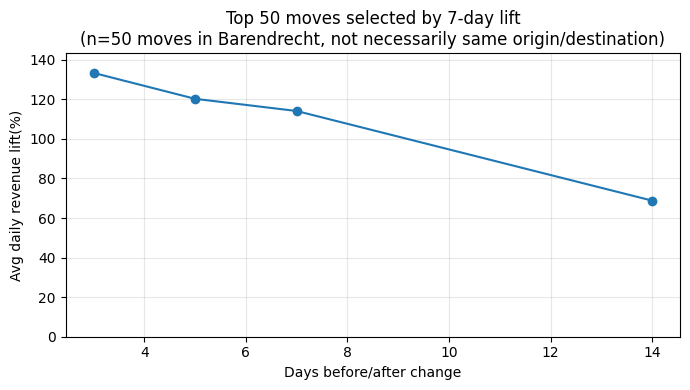

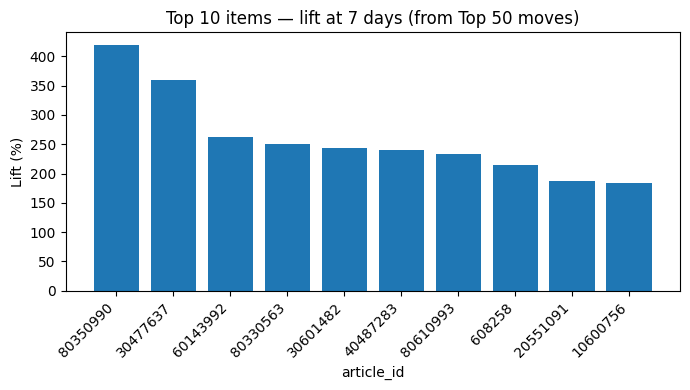

  from_loc  to_loc  moves
0   M15V13  M15U14      4
1   M18J06  M18G10      4
2   M16A09  M16A08      2
3   M14R13  M14S13      2
4   M15S17  M15U16      2


In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- settings ---
windows = [3, 5, 7, 14]
min_days = 3
base_window = 7   # window used to pick top 50 moves

# --- data ---
df = sales_art_ts[sales_art_ts["article_id"].isin(df_only_hp["article_id"])].copy()
df["date"] = pd.to_datetime(df["date"])

df["loc"] = df["sales_location_id"].astype(str).str.upper().str.extract(r"(M\d{2}[A-Z]\d{2})")[0]
df = df[df["loc"].notna()].sort_values(["article_id", "date"]).copy()

df["prev_loc"] = df.groupby("article_id")["loc"].shift(1)
moves = df[(df["loc"] != df["prev_loc"]) & df["prev_loc"].notna()].copy()
moves = moves[["article_id", "date", "prev_loc", "loc"]].rename(
    columns={"date": "move_date", "prev_loc": "from_loc", "loc": "to_loc"}
)

# --- compute lift with "clean window" rule ---
results = []
for w in windows:
    need = min(min_days, w)

    for i in range(len(moves)):
        art = moves.iloc[i]["article_id"]
        d0 = moves.iloc[i]["move_date"]
        from_loc = moves.iloc[i]["from_loc"]
        to_loc = moves.iloc[i]["to_loc"]
## checking if the in w days before or after, there was another change 
        other = moves[(moves["article_id"] == art) & (moves["move_date"] != d0)]
        if ((other["move_date"] >= d0 - pd.Timedelta(days=w)) &
            (other["move_date"] <= d0 + pd.Timedelta(days=w))).any():
            continue

        pre = df[(df["article_id"] == art) &
                 (df["date"] >= d0 - pd.Timedelta(days=w)) &
                 (df["date"] <  d0) &
                 (df["loc"] == from_loc)]

        post = df[(df["article_id"] == art) &
                  (df["date"] >  d0) &
                  (df["date"] <= d0 + pd.Timedelta(days=w)) &
                  (df["loc"] == to_loc)]

        pre_days = pre["date"].nunique()
        post_days = post["date"].nunique()

        if pre_days < need or post_days < need:
            continue

        pre_avg = pre["revenue"].sum() / pre_days
        post_avg = post["revenue"].sum() / post_days
        if pre_avg <= 0:
            continue

        lift_pct = 100 * (post_avg - pre_avg) / pre_avg

        results.append({
            "article_id": art,
            "move_date": d0,
            "from_loc": from_loc,
            "to_loc": to_loc,
            "window_days": w,
            "lift_pct": lift_pct
        })

lifts = pd.DataFrame(results)

if lifts.empty:
    print("No valid moves found (check windows/min_days or data coverage).")
else:
    # --- pick top 50 moves by lift at base_window (analysis stays top 50) ---
    top50 = (lifts[lifts["window_days"] == base_window]
             .sort_values("lift_pct", ascending=False)
             .head(50)[["article_id", "move_date"]])

    lifts_top = lifts.merge(top50, on=["article_id", "move_date"], how="inner")

    # --- plot 1: mean lift vs window for top 50 moves ---
    mean_lift = lifts_top.groupby("window_days")["lift_pct"].mean().reset_index()

    plt.figure(figsize=(7, 4))
    plt.ylim(0, mean_lift.lift_pct.max()+10)        
    plt.plot(mean_lift["window_days"], mean_lift["lift_pct"], marker="o")
   # plt.axhline(0, linestyle="--")
    
    #plt.title(f"Sales lift after grid change (Top 50 moves by {base_window}d lift)")
    plt.title(
        "Top 50 moves selected by 7-day lift\n"
        "(n=50 moves in Barendrecht, not necessarily same origin/destination)"
    )
    plt.xlabel("Days before/after change")
    plt.ylabel("Avg daily revenue lift(%)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- plot 2: bar chart of TOP 10 items (but still from top 50 pool) ---
    base = (lifts_top[lifts_top["window_days"] == base_window]
            .sort_values("lift_pct", ascending=False)
            .copy())

    # keep only top 10 bars
    base10 = base.head(10)

    plt.figure(figsize=(7, 4))
    plt.bar(base10["article_id"].astype(str), base10["lift_pct"])
   # plt.axhline(0, linestyle="--")
    plt.title(f"Top 10 items — lift at {base_window} days (from Top 50 moves)")
    plt.xlabel("article_id")
    plt.ylabel("Lift (%)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
pairs = (lifts_top[lifts_top["window_days"] == base_window]
         .groupby(["from_loc","to_loc"])
         .size()
         .sort_values(ascending=False)
         .head(5)
         .reset_index(name="moves"))
print(pairs)



In [206]:
mean_lift

,window_days,lift_pct
0,3,133.385577
1,5,120.284314
2,7,114.124532
3,14,68.822467


### end of ranking top moves

## Identify and visualize the change of position and the corresponing puntual revenue item selected

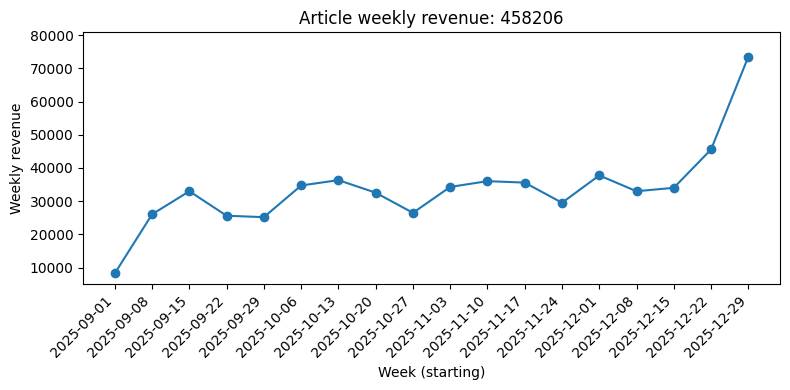

In [192]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

#ARTICLE = 10600756 #60143992
ARTICLE = 458206
end_date = "2025-12-31"   # <-- up to this day

# ---------- 1) weekly series ----------
w = article_weekly.loc[article_weekly["article_id"] == ARTICLE, ["date", "article_revenue_weekly"]].copy()
w["date"] = pd.to_datetime(w["date"])
w = w.sort_values("date")

# keep only weeks up to end_date
w = w[w["date"] <= pd.to_datetime(end_date)].copy()

# ---------- 2) find change dates from daily data ----------
d = sales_art_ts.loc[sales_art_ts["article_id"] == ARTICLE, ["date", "sales_location_id"]].copy()
d["date"] = pd.to_datetime(d["date"])
d = d.sort_values("date")

# keep only daily rows up to end_date (so changes after are not shown)
d = d[d["date"] <= pd.to_datetime(end_date)].copy()

d["loc"] = d["sales_location_id"].astype(str).str.upper().str.extract(r"(M\d{2}[A-Z]\d{2})")[0]
change_dates = d.loc[d["loc"].ne(d["loc"].shift()) & d["loc"].notna() & d["loc"].shift().notna(), "date"]

# map change date -> week start (Monday)
change_weeks = change_dates.dt.to_period("W-MON").dt.start_time.unique()

# ---------- 3) plot weekly + vertical lines ----------
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(w["date"], w["article_revenue_weekly"], marker="o")

ymax = w["article_revenue_weekly"].max()

for cw in change_weeks:
    ax.axvline(cw, linestyle="--", linewidth=1, alpha=0.8)
    ax.text(pd.to_datetime(cw) - pd.Timedelta(days=1), ymax * 0.6,
            pd.to_datetime(cw).strftime("%Y-%m-%d"),
            rotation=90, va="bottom", ha="center", fontsize=8)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
fig.autofmt_xdate(rotation=45, ha="right")

ax.set_xlabel("Week (starting)")
ax.set_ylabel("Weekly revenue")
ax.set_title(f"Article weekly revenue: {ARTICLE}")
ax.set_ylim(top=ymax * 1.1)

plt.tight_layout()
plt.show()


In [195]:
df_art

,date,revenue,sales_location_id,loc
185,2025-09-01,8243.75,"[000500, 500200, 500100, 302400, 302500]",NaN
4143,2025-09-02,6508.20,"[000500, 500200, 500100, 302400, 302500]",NaN
7920,2025-09-03,867.80,"[000500, 500200, 500100, 302400, 302500]",NaN
11898,2025-09-04,1301.70,"[000500, 500200, 500100, 302400, 302500]",NaN
15711,2025-09-05,7376.00,"[000500, 500200, 500100, 302400, 302500]",NaN
...,...,...,...,...
480501,2025-12-27,9111.62,"[000500, 303700, 303800, 303500, 303900, 30360...",NaN
485700,2025-12-28,15186.01,"[000500, 303700, 303800, 303500, 303900, 30360...",NaN
490547,2025-12-29,13363.63,"[303800, 303500, 303900, 303600, 303400, 30370...",NaN
495987,2025-12-30,10933.79,"[303800, 303500, 303900, 303600, 303400, 30370...",NaN


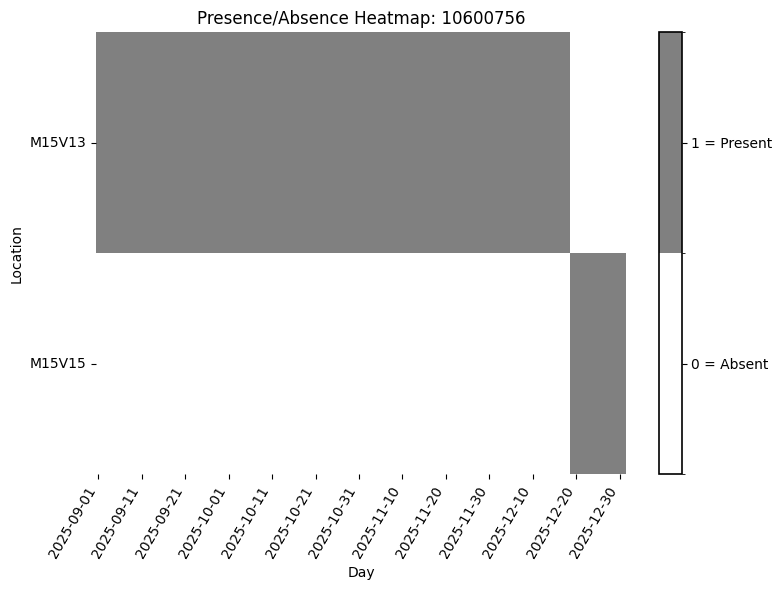

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

temp_ts = time_series_df[time_series_df["article_id"] == ARTICLE]

temp_ts = pd.concat(
    [temp_ts, pd.get_dummies(temp_ts["sales_location_id"])],
    axis=1
).drop(columns=["sales_location_id"]).reset_index(drop=True)

temp_ts = temp_ts.loc[:, (temp_ts != 0).any(axis=0)]
temp_ts = temp_ts.groupby(["date", "article_id"]).sum().reset_index()

temp_ts["date"] = pd.to_datetime(temp_ts["date"])
temp_ts = temp_ts.sort_values("date")
temp_ts = temp_ts.set_index("date").drop(columns="article_id")

start_date = "2025-09-01"  # <-- from this day
end_date = "2025-12-31"  # <-- up to this day
temp_ts = temp_ts.loc[start_date:end_date]

# Heatmap data (rows=locations, cols=dates)
data = temp_ts.T

# Make it strictly binary: 1=present, 0=absent
data = (data > 0).astype(int)

# --- Colormap: 0=white, 1=gray ---
cmap = ListedColormap(["white", "gray"])
norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)

fig, ax = plt.subplots(figsize=(8, 6))
hm = sns.heatmap(
    data,
    cmap=cmap,
    norm=norm,
    annot=False,
    ax=ax,
    cbar=True,
    cbar_kws={"ticks": [0, 1]}
)
cbar = hm.collections[0].colorbar

# black border around the colorbar
cbar.outline.set_edgecolor("black")
cbar.outline.set_linewidth(1.2)

# Colorbar labels
cbar = hm.collections[0].colorbar
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["0 = Absent", "1 = Present"])

ax.set_title(f"Presence/Absence Heatmap: {ARTICLE}")
ax.set_xlabel("Day")
ax.set_ylabel("Location")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# ---- Fix x ticks: put labels at cell centers ----
dates = temp_ts.index.strftime("%Y-%m-%d").tolist()
n = len(dates)
step = max(1, n // 12)

tick_pos = np.arange(0, n, step) + 0.5
tick_lab = [dates[i] for i in range(0, n, step)]

ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_lab, rotation=60, ha="right")

plt.tight_layout()
plt.show()


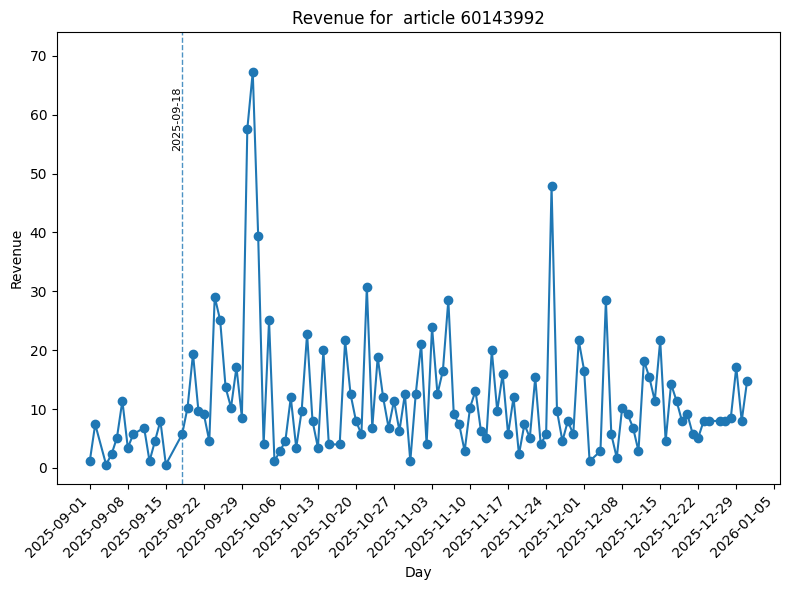

In [207]:
## the following graph makes sense only in case of 1 location because of the vertical line showing exactly the change date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


ARTICLE = 60143992 #10600756 #60143992

start_date = "2025-09-01"  # <-- from this day
end_date = "2025-12-31"  # <-- up to this day

df_art = sales_art_ts.loc[sales_art_ts["article_id"] == ARTICLE,
                          ["date", "revenue", "sales_location_id"]].copy()
df_art["date"] = pd.to_datetime(df_art["date"])
df_art = df_art.sort_values("date")

# keep only dates up to 2025-10-05
df_art = df_art[(df_art["date"] <= pd.to_datetime(end_date)) & (df_art["date"] >= pd.to_datetime(start_date))].copy()

# clean location code
df_art["loc"] = df_art["sales_location_id"].astype(str).str.upper().str.extract(r"(M\d{2}[A-Z]\d{2})")[0]

# dates where location changes vs previous row
change_dates = df_art.loc[df_art["loc"].ne(df_art["loc"].shift()), "date"].iloc[1:]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df_art["date"], df_art["revenue"], marker="o")

ymax = df_art["revenue"].max()
for d in change_dates:
    ax.axvline(d, linestyle="--", linewidth=1, alpha=0.8)
    ax.text(d - pd.Timedelta(days=1), ymax * 0.8, d.strftime("%Y-%m-%d"),
            rotation=90, va="bottom", ha="center", fontsize=8)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
fig.autofmt_xdate(rotation=45, ha="right")

ax.set_xlabel("Day")
ax.set_ylabel("Revenue")
ax.set_title(f"Revenue for  article {ARTICLE}")
ax.set_ylim(top=ymax * 1.1)

plt.tight_layout()
plt.show()


In [209]:

df_art.to_csv("art_60143992.csv", index=False)


In [84]:
temp_ts = time_series_df[time_series_df["article_id"] == ARTICLE]

temp_ts = pd.concat([temp_ts,pd.get_dummies(temp_ts["sales_location_id"])], axis=1).drop(columns=["sales_location_id"]).reset_index(drop=True)

temp_ts = temp_ts.loc[:, (temp_ts != 0).any(axis=0)]
# print(temp_ts.head(10))


temp_ts = temp_ts.groupby(["date","article_id"]).sum().reset_index()

temp_ts["date"] = temp_ts.reset_index()["date"].dt.strftime('%Y-%m-%d')
temp_ts = temp_ts.set_index("date").drop(columns="article_id")

start_date = '2025-09-01'
end_date   = '2026-20-01'
temp_ts = temp_ts.loc[start_date:end_date]
temp_ts.tail(50)

,S03I22,S03I23
date,,
2025-11-30,0,1
2025-12-01,0,1
2025-12-02,0,1
2025-12-03,0,1
2025-12-04,0,1
2025-12-05,0,1
2025-12-06,0,1
2025-12-07,0,1
2025-12-08,0,1


## Overall number of item per location
Objective: see the distribution of items with 1 or more than 1 locations 

In [170]:
def get_item_locations(query: bool, saved_path=None):
    """
    Get the questions raw data

    @param query: If True query to get the data, else read from file
    @return: raw data DataFrame
    """

    if query:
        code ="""
/* to add : if sales location id is in MH or SW*/
WITH
  bu_name AS (
    SELECT
      cmpd.bu_code AS cmp_code,
      cmpd.bu_name AS cmp_name,
      concat(cmpd.bu_code, ' - ', cmpd.bu_name) AS cmp_code_name,
      countryd.country_name AS cmp_market_fullname
    FROM `ingka-sbpdp-ecbd-prod.dm_bu_master_no_pii.cmp_dim_v2` cmpd
    LEFT JOIN `ingka-sbpdp-ecbd-prod.dm_geo_ref_no_pii.country_dim_v2` countryd
      ON
        cmpd.country_code = countryd.country_code
        AND countryd.scd_curr_ind = 'Y'
    WHERE
      1 = 1
      AND cmpd.scd_curr_ind = 'Y'
  ),
  item_location AS (
    SELECT
      article_id,
      bu_code,
      sales_location_id,
      CASE
        WHEN location_type = '1' THEN 'H'
        WHEN location_type = '2' THEN 'P'
        WHEN location_type = '3' THEN 'HP'
        WHEN location_type = '0' THEN 'Addons'
        ELSE 'Other'
        END
        AS location_type_derived,
      /* identify the type of sales location*/
      CASE
        WHEN
          REGEXP_CONTAINS(
            UPPER(TRIM(sales_location_id)),
            r'^(?:S|M)\d{2}[A-Z]\d{2}$')
          THEN 'is_market_show'
        WHEN
          REGEXP_CONTAINS(TRIM(sales_location_id), r'^\d{6}$')
          THEN 'is_self_area'
        ELSE 'Other'
        END
        AS type_location_id,
      location_type,
      assigned_sales_space_quantity,
      PARSE_DATE('%Y%m%d', from_date) AS from_date,
      # nex import_date is the until_date with the condition of row_numb = 1
      import_date AS till_date,
      active,
      ROW_NUMBER()
        OVER (
          PARTITION BY article_id, bu_code, sales_location_id, from_date
          ORDER BY CAST(import_date AS DATE) DESC
        ) AS row_num
    FROM
      `ingka-cff-slm-prod.slm.article_location_weekly`
    WHERE
      -- bu_code = "274"
      -- AND
      import_date >= '2025-09-01'
      AND import_date < '2025-12-31'
      AND active = '1'
    QUALIFY row_num = 1
  ),
  per_article AS (
    SELECT
      bu_code,
      article_id,
      MAX(CASE WHEN location_type = '3' THEN 1 ELSE 0 END) AS has_hp,
      MAX(CASE WHEN location_type != '3' THEN 1 ELSE 0 END) AS has_other_hp,
      MAX(CASE WHEN location_type = '0' THEN 1 ELSE 0 END) AS has_addons,
      MAX(CASE WHEN type_location_id = 'is_market_show' THEN 1 ELSE 0 END)
        AS is_market_show,
      MAX(CASE WHEN type_location_id = 'is_self_area' THEN 1 ELSE 0 END)
        AS is_self_area
    FROM item_location
    GROUP BY article_id, bu_code
  )
SELECT  -- COUNT(*) AS n_article_only_hp
  bu_code,
  bu_name.cmp_code_name,
  bu_name.cmp_market_fullname,
  COUNT(CASE WHEN has_hp = 1 AND has_other_hp = 0 THEN article_id END)
    AS only_hp,
  COUNT(CASE WHEN has_hp = 0 AND has_other_hp = 1 THEN article_id END)
    AS only_other,
  COUNT(CASE WHEN has_hp = 1 AND has_other_hp = 1 THEN article_id END)
    AS hp_other,
  COUNT(CASE WHEN has_addons = 1 THEN article_id END) AS addons,
  COUNT(
    CASE
      WHEN has_hp = 1 AND has_other_hp = 0 AND is_market_show = 1
        THEN article_id
      END)
    AS only_hp_mk_or_shw,
  COUNT(
    CASE
      WHEN has_hp = 1 AND has_other_hp = 0 AND is_self_area = 1 THEN article_id
      END)
    AS only_hp_self,
  COUNT(*) AS tot_item
FROM per_article AS art_db
LEFT JOIN bu_name AS bu_name
  ON art_db.bu_code = bu_name.cmp_code
-- WHERE has_hp = 1
-- AND has_other_hp = 0;
WHERE cmp_market_fullname LIKE '%NETHERLANDS%'
GROUP BY bu_code, cmp_code_name, cmp_market_fullname

            """
        
        job=client.query(code)
        
        df=job.to_dataframe()

        if saved_path is not None:
            df.to_csv(saved_path, index=False)
    else:
        df = pd.read_csv(saved_path)
    return df


In [171]:
df = get_item_locations(query=True)
df.head()

E0000 00:00:1769415420.205207 30097168 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


,bu_code,cmp_code_name,cmp_market_fullname,only_hp,only_other,hp_other,addons,only_hp_mk_or_shw,only_hp_self,tot_item
0,378,378 - IKEA Haarlem,NETHERLANDS,7487,142,2638,2612,4058,3268,10267
1,089,089 - IKEA Heerlen,NETHERLANDS,8537,113,2581,2503,3995,4044,11231
2,088,088 - IKEA Amsterdam,NETHERLANDS,7735,189,2207,2179,4222,3431,10131
3,403,403 - IKEA Breda,NETHERLANDS,7749,92,2769,2758,3999,3774,10610
4,1009,1009 - IKEA Leeuwarden De Centrale,NETHERLANDS,102,0,2,2,0,0,104


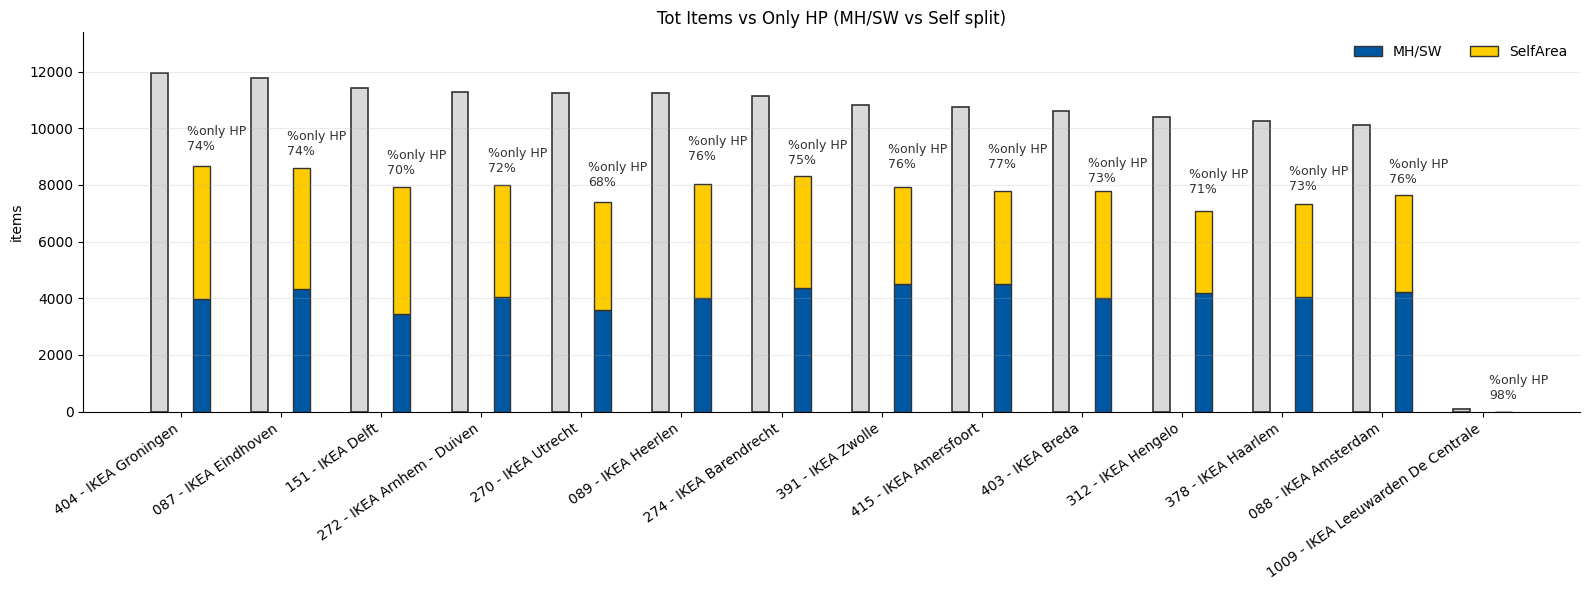

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

df["pct_only_hp"] = df["only_hp"] / df["tot_item"] * 100
df = df.sort_values("tot_item", ascending=False).reset_index(drop=True)

# --- layout params (tune these) ---
group_gap = 1.55
w = 0.26
offset = 0.65  # <<< increase this to push Only HP further right (e.g., 0.65)

x_total = [i * group_gap for i in range(len(df))]
x_hp = [x + offset for x in x_total]
x_mid = [(a + b) / 2 for a, b in zip(x_total, x_hp)]

# --- colors ---
total_grey = "#d9d9d9"
ikea_blue = "#0058A3"
ikea_yellow = "#FFCC00"

fig, ax = plt.subplots(figsize=(16, 6))

# Total bar (grey)
ax.bar(
    x_total, df["tot_item"], width=w,
    edgecolor="#333333", facecolor=total_grey, linewidth=1.2
)

# Only HP stacked (blue + yellow)
ax.bar(
    x_hp, df["only_hp_mk_or_shw"], width=w,
    edgecolor="#333333", color=ikea_blue, linewidth=1.0, label="MH/SW"
)
ax.bar(
    x_hp, df["only_hp_self"], bottom=df["only_hp_mk_or_shw"], width=w,
    edgecolor="#333333", color=ikea_yellow, linewidth=1.0, label="SelfArea"
)

# % only HP label in the middle gap
ymax = df["tot_item"].max()
pad = ymax * 0.02

# move ONLY the label to the right (in x units)
label_dx = 0.10   # <-- increase/decrease to taste

for i, row in df.iterrows():
    x_label = (x_total[i] + x_hp[i]) / 2 + label_dx  # shift text only
    ax.text(
        x_label, row["only_hp"] + pad,
        f'%only HP\n{row["pct_only_hp"]:.0f}%',
        ha="left", va="bottom", fontsize=9, color="#333333"
    )


# Cosmetics
ax.set_xticks(x_mid)
ax.set_xticklabels(df["cmp_code_name"], rotation=35, ha="right")
ax.set_ylabel("items")
ax.set_title("Tot Items vs Only HP (MH/SW vs Self split)")
ax.grid(axis="y", alpha=0.25)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(0, ymax * 1.12)
ax.legend(frameon=False, ncols=2, loc="upper right")

plt.tight_layout()
plt.show()


In [173]:
df["pct_only_hp"].mean()

75.30046622464356